In [1]:
import math, sys, os, numpy as np
from numpy.linalg import norm
from matplotlib import pyplot as plt
%matplotlib inline
import torch
import torchvision
from torchvision import models, transforms, datasets

In [2]:
import torch.nn as nn
import torch.nn.functional as F


In [3]:
## Defining Blue print
class classifier(nn.Module):
    
    def __init__(self):
        super(classifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1)
        self.fc = nn.Linear(in_features=128, out_features=2)
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x,7)
        x = self.fc(torch.flatten(x, start_dim=1))
        return F.log_softmax(x, dim=1)
    
        

In [4]:
?torch.max_pool2d

In [5]:
conv_class = classifier()

In [6]:
root_dir = './data/MNIST/'
torchvision.datasets.MNIST(root=root_dir, download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 93304019.45it/s]


Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 46341122.35it/s]


Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 41129542.23it/s]


Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 11687440.96it/s]


Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/MNIST/
    Split: Train

In [7]:
train_set = torchvision.datasets.MNIST(root=root_dir, train=True, download = True)

In [8]:
# MNIST_dataset = torch.utils.data.DataLoader(train_set, batch)
images = train_set.data.numpy().astype(np.float32)/255
labels = train_set.targets.numpy()
n = len(images)

eights = [images[i] for i in range(n) if labels[i]==8]
ones = [images[i] for i in range(n) if labels[i]==1]



In [9]:
batch_3images = train_set.data[0:2].type(torch.FloatTensor).resize_(3,1,28,28)
conv_class(batch_3images).shape


torch.Size([3, 2])

In [10]:



bs = 64

l8 = np.array(0)
eights_dataset = [[torch.from_numpy(e.astype(np.float32)).unsqueeze(0), torch.from_numpy(l8.astype(np.int64))] for e in eights]
l1 = np.array(1)
ones_dataset = [[torch.from_numpy(e.astype(np.float32)).unsqueeze(0), torch.from_numpy(l1.astype(np.int64))] for e in ones]
train_dataset = eights_dataset[1000:] + ones_dataset[1000:]
test_dataset = eights_dataset[:1000] + ones_dataset[:1000]

train_loader = torch.utils.data.DataLoader(train_dataset,
    batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,
    batch_size=bs, shuffle=True)

In [11]:
def train(model, data_loader, loss_fn, optimizer, n_epochs=1):
    model.train(True)
    loss_train = np.zeros(n_epochs)
    acc_train = np.zeros(n_epochs)
    
    for epoch_num in range(n_epochs):
        running_corrects = 0.0 
        running_loss = 0.0  
        size = 0
        
        for data in data_loader:
            inputs, labels = data
            bs = labels.size(0)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds==labels)
            running_loss += loss.data
            size += bs
        
        epoch_loss = running_loss.item() / size
        epoch_acc = running_corrects.item() / size
        loss_train[epoch_num] = epoch_loss
        acc_train[epoch_num] = epoch_acc
        print('Train :: Loss:{:.4f} Acc:{:.4f}'.format(epoch_loss, epoch_acc))
    
    return loss_train, acc_train

            













In [12]:
conv_class = classifier()
loss_fn = nn.NLLLoss()
learning_rate = 1e-3
optimizer_cl = torch.optim.Adam(conv_class.parameters(), lr = learning_rate)
l_t, a_t = train(conv_class, train_loader, loss_fn, optimizer_cl, n_epochs=10)

Train :: Loss:0.0065 Acc:0.8900
Train :: Loss:0.0018 Acc:0.9803
Train :: Loss:0.0009 Acc:0.9872
Train :: Loss:0.0007 Acc:0.9904
Train :: Loss:0.0005 Acc:0.9918
Train :: Loss:0.0004 Acc:0.9926
Train :: Loss:0.0004 Acc:0.9934
Train :: Loss:0.0003 Acc:0.9939
Train :: Loss:0.0003 Acc:0.9947
Train :: Loss:0.0003 Acc:0.9949


In [13]:
l_t, a_t = train(conv_class, train_loader, loss_fn, optimizer_cl, n_epochs=10)

Train :: Loss:0.0003 Acc:0.9950
Train :: Loss:0.0002 Acc:0.9949
Train :: Loss:0.0002 Acc:0.9953
Train :: Loss:0.0002 Acc:0.9959
Train :: Loss:0.0002 Acc:0.9965
Train :: Loss:0.0002 Acc:0.9961
Train :: Loss:0.0002 Acc:0.9961
Train :: Loss:0.0002 Acc:0.9968
Train :: Loss:0.0002 Acc:0.9969
Train :: Loss:0.0002 Acc:0.9968


In [14]:
def test(model,data_loader):
    model.train(False)

    running_corrects = 0.0
    running_loss = 0.0
    size = 0

    for data in data_loader:
        inputs, labels = data
            
        bs = labels.size(0)
        outputs = model(inputs)
        loss = loss_fn(outputs,labels)
            
        _,preds = torch.max(outputs,1)
        running_corrects += torch.sum(preds == labels)
        running_loss += loss.data
        size += bs

    print('Test - Loss: {:.4f} Acc: {:.4f}'.format(running_loss / size, running_corrects.item() / size))

In [15]:
test(conv_class, test_loader)

Test - Loss: 0.0003 Acc: 0.9940


In [16]:
# ## changing to Adam optimizer
## Ooopps  seems like we've already done that before
## But why not, Lets do it again
optimizer_cl = torch.optim.Adam(conv_class.parameters(), lr=learning_rate)
l_t, a_t = train(conv_class, train_loader, loss_fn, optimizer_cl, n_epochs=10)


Train :: Loss:0.0002 Acc:0.9966
Train :: Loss:0.0002 Acc:0.9975
Train :: Loss:0.0002 Acc:0.9970
Train :: Loss:0.0001 Acc:0.9972
Train :: Loss:0.0001 Acc:0.9975
Train :: Loss:0.0001 Acc:0.9980
Train :: Loss:0.0001 Acc:0.9977
Train :: Loss:0.0001 Acc:0.9976
Train :: Loss:0.0001 Acc:0.9977
Train :: Loss:0.0001 Acc:0.9984


In [17]:
for m in conv_class.children():
    print('weights :', m.weight.data)
    print('bias :', m.bias.data)

weights : tensor([[[[ 0.7803, -0.2295, -0.9880],
          [ 0.3726,  0.4454, -0.0870],
          [-0.2606,  0.5249,  0.8825]]],


        [[[ 0.7108,  0.2464, -0.7742],
          [ 0.3747,  0.3153, -0.9276],
          [ 0.3337,  0.4773, -0.0121]]],


        [[[ 0.5169,  0.6250,  0.6077],
          [ 0.0578, -0.2236,  0.1822],
          [-0.4724, -0.6939,  0.1464]]],


        [[[-0.9712, -0.7714, -0.4128],
          [-0.7989,  0.6967,  0.4240],
          [-0.9365, -0.1658,  0.1551]]],


        [[[-0.5418, -0.6974, -1.1919],
          [ 0.8025,  0.0107, -0.4109],
          [ 0.0493, -0.7430, -1.3474]]],


        [[[-0.2523, -0.5415,  0.1604],
          [-0.4445,  0.3566,  0.4299],
          [ 0.6021,  0.2318, -0.2878]]],


        [[[ 0.6025,  0.6631, -0.1915],
          [ 0.5186,  0.3643, -0.8599],
          [ 0.6104,  0.2198, -0.7578]]],


        [[[-0.3057,  0.2708,  0.5477],
          [ 0.1401,  0.1992,  0.5147],
          [ 0.5438,  0.5418,  0.3747]]]])
bias : tensor([-0.0471,

In [18]:
for m in conv_class.children():
    T_w = m.weight.data.numpy()
    T_b = m.bias.data.numpy()
    break

In [19]:
# plot multiple images
def plots(ims, interp=False, titles=None):
    ims=np.array(ims)
    mn,mx=ims.min(),ims.max()
    f = plt.figure(figsize=(12,24))
    for i in range(len(ims)):
        sp=f.add_subplot(1, len(ims), i+1)
        if not titles is None: sp.set_title(titles[i], fontsize=18)
        plt.imshow(ims[i], interpolation=None if interp else 'none', vmin=mn,vmax=mx)

# plot a single image
def plot(im, interp=False):
    f = plt.figure(figsize=(3,6), frameon=True)
    plt.imshow(im, interpolation=None if interp else 'none')

plt.gray()
plt.close()

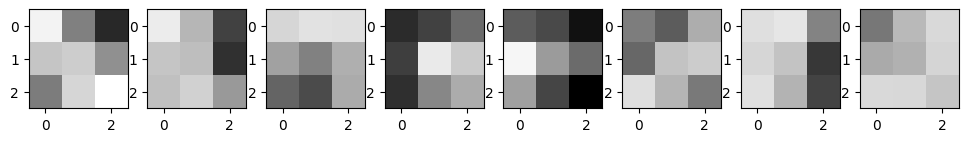

In [20]:
plots([T_w[i][0] for i in range(8)]) ## Visual Representation of our learned parameters



In [21]:
## finally our bias params and its value
T_b

array([-0.04707443, -0.01224539, -0.4437675 ,  0.43727365,  0.32028368,
       -0.33513963, -0.25911698,  0.40144417], dtype=float32)